In [171]:
%reset -f
import sys
sys.path.append('/home/psimmerl/mds_analysis')

import pathlib

import math
import numpy as np
import numba as nb
from math import ceil, floor

from src.histo_utilities import std_color_list as SCL
# from src.helper_functions import alert, Table, weight_calc

from src import CMS_lumi, tdrstyle
root_style = tdrstyle.setTDRStyle()

import ROOT as rt
from ROOT import RDataFrame
from ROOT import TCanvas, TLatex, TLegend, TLine, TBox
from ROOT import TH1D, TH2D, TGraph, TGraphErrors, TGraphAsymmErrors

# **************** #

CTAU = 1000
# CTAUS = np.round(np.logspace(2, 4, 10), 0)
# CTAUS = np.round(np.logspace(1, 7, 55), 0)
CTAUS = np.round(np.logspace(1, 5, 30), 0)
if CTAU not in CTAUS:
    CTAUS = np.append(CTAUS, CTAU)
    CTAUS = np.sort(CTAUS)

# **************************** #
LOCAL_DIR = '/home/psimmerl/mds_analysis'
OUT_DIR = f'{LOCAL_DIR}/reports/weekly/2024-04-15'

# **** #
YEAR = ('2022', '2023')[0]
MET_CATEGORY = ('lt200', 'low', 'high')[1]
TAG_CATEGORY = ('csccsc', 'cscdt')[0]
CUTSET = ('l1', 'scs', 'ropt', 'roptDNN', 'ropt_bkgMC_plusBeamHalo', 'tight')[-1]
OOT = False#True#

SIZE_VAR = TAG_CATEGORY[3:]

FN_MC = f'{LOCAL_DIR}/data/processed/mc_{TAG_CATEGORY}_{CUTSET}_{MET_CATEGORY}_{YEAR}_rdf.root'
# FN_MC = f'{LOCAL_DIR}/data/processed/mc_{TAG_CATEGORY}{"OOT" if OOT else ""}_{CUTSET}_{MET_CATEGORY}_rdf.root'
FN_R3 = f'{LOCAL_DIR}/data/processed/r3_{TAG_CATEGORY}{"OOT" if OOT else ""}_{CUTSET}_{MET_CATEGORY}_{YEAR}_rdf.root'

# **** #
# tight 2022
if f"{TAG_CATEGORY}_{CUTSET}_{MET_CATEGORY}_{YEAR}" == "csccsc_tight_low_2022":
    ABCD_DPHI = 2.90
    ABCD_SIZE = 140
if f"{TAG_CATEGORY}_{CUTSET}_{MET_CATEGORY}_{YEAR}" == "csccsc_tight_high_2022":
    ABCD_DPHI = 1.95
    ABCD_SIZE = 100

if f"{TAG_CATEGORY}_{CUTSET}_{MET_CATEGORY}_{YEAR}" == "cscdt_tight_low_2022":
    ABCD_DPHI = 2.35
    ABCD_SIZE = 129
if f"{TAG_CATEGORY}_{CUTSET}_{MET_CATEGORY}_{YEAR}" == "cscdt_tight_high_2022":
    ABCD_DPHI = 2.55
    ABCD_SIZE = 113

# tight 2023
if f"{TAG_CATEGORY}_{CUTSET}_{MET_CATEGORY}_{YEAR}" == "csccsc_tight_low_2023":
    ABCD_DPHI = 2.90
    ABCD_SIZE = 146
if f"{TAG_CATEGORY}_{CUTSET}_{MET_CATEGORY}_{YEAR}" == "csccsc_tight_high_2023":
    ABCD_DPHI = 2.00
    ABCD_SIZE = 96

if f"{TAG_CATEGORY}_{CUTSET}_{MET_CATEGORY}_{YEAR}" == "cscdt_tight_low_2023":
    ABCD_DPHI = 2.55
    ABCD_SIZE = 123
if f"{TAG_CATEGORY}_{CUTSET}_{MET_CATEGORY}_{YEAR}" == "cscdt_tight_high_2023":
    ABCD_DPHI = 1.45
    ABCD_SIZE = 119

# **** #
pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# rt.gErrorIgnoreLevel = 1001  # rt.kInfo + 1
# rt.gROOT.SetBatch(True)
PI = rt.TMath.Pi()

# rt.EnableImplicitMT(4)
# print('Enabled ROOT\'s implicit multithreading (sometimes causes a crash)')

gc = []

# **************** #
print(f'{MET_CATEGORY=}')
print(f'{TAG_CATEGORY=}')
print(f'{CUTSET=}')
print(f'{OOT=}')
print('')

print(f'{ABCD_DPHI=}')
print(f'{ABCD_SIZE=}')
print('')

print(f'{FN_MC=}')
print(f'{FN_R3=}')
print(f'{OUT_DIR=}')
print('')

# **************** #
rdfs = {
    'mc' : RDataFrame('MuonSystem_flat', FN_MC),
    'r3' : RDataFrame('MuonSystem_flat', FN_R3),
}

print('Events Read:')
for key, rdf in rdfs.items():
    if TAG_CATEGORY == 'csccsc':
        # rdf = rdf.Filter('tag_dR > 1.5')
        rdf = rdf.Alias('tag_size', 'csc1Size')
        rdf = rdf.Alias('tag_ctau', 'csc1CTau')

    if TAG_CATEGORY == 'cscdt':
        # rdf = rdf.Filter('tag_dPhi > 0.4')
        rdf = rdf.Alias('tag_size', 'dtSize')
        rdf = rdf.Alias('tag_ctau', 'dtCTau')

    count, weight = rdf.Count().GetValue(), rdf.Sum('weight').GetValue()
    print(f'  {key} = {count:,} ({weight:,.2f})')

    rdfs[key] = rdf


MET_CATEGORY='high'
TAG_CATEGORY='cscdt'
CUTSET='tight'
OOT=False

ABCD_DPHI=1.45
ABCD_SIZE=119

FN_MC='/home/psimmerl/mds_analysis/data/processed/mc_cscdt_tight_high_2023_rdf.root'
FN_R3='/home/psimmerl/mds_analysis/data/processed/r3_cscdt_tight_high_2023_rdf.root'
OUT_DIR='/home/psimmerl/mds_analysis/reports/weekly/2024-04-15'

Events Read:
  mc = 25 (33.79)
  r3 = 1 (1.00)


In [172]:
# rdfs['r3'] = rdfs['mc'].Redefine('weight', '0*weight')

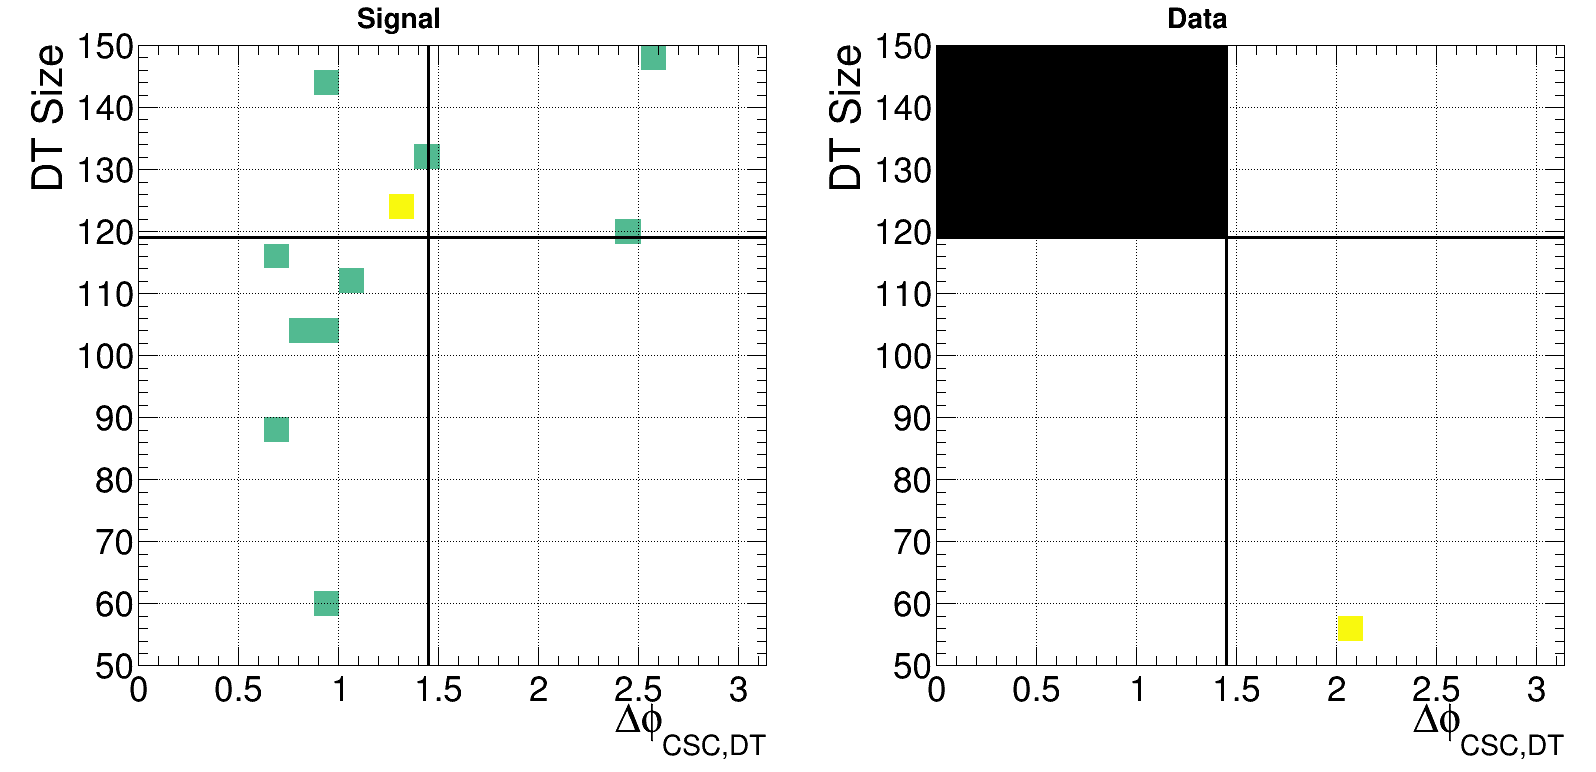

In [173]:
canvas = TCanvas('','',2*800,800)
canvas.Divide(2,1)

dopt = ('col','box')[0]
nb = 25

form = ('',f';#Delta#phi_{{CSC,{SIZE_VAR.upper()}}};{SIZE_VAR.upper()} Size;count',nb,0,np.pi,nb,50,150)

dphi_line = TLine(ABCD_DPHI,50,ABCD_DPHI,150)
size_line = TLine(0,ABCD_SIZE,np.pi,ABCD_SIZE)
dphi_line.SetLineWidth(3)
size_line.SetLineWidth(3)

if 'high' in FN_R3:
    sr_box = TBox(0, ABCD_SIZE, ABCD_DPHI, 150)
else:# 'low' in FN_R3:
    sr_box = TBox(ABCD_DPHI, ABCD_SIZE, np.pi, 150)
sr_box.SetFillColor(rt.kBlack)

latex = TLatex()
latex.SetTextAlign(23)
latex.SetTextSize(0.04)

canvas.cd(1).SetGrid()
h_mc = rdfs['mc'].Histo2D(form,'tag_dPhi','tag_size').GetValue()
h_mc.Draw(dopt)

dphi_line.Draw()
size_line.Draw()
latex.DrawLatexNDC(0.5, 1, 'Signal'+(f', {SIZE_VAR.upper()}_{{OOT}}' if 'OOT' in FN_MC else ''))

canvas.cd(2).SetGrid()
h_r3 = rdfs['r3'].Histo2D(form,'tag_dPhi','tag_size').GetValue()
h_r3.Draw(dopt)

dphi_line.Draw()
size_line.Draw()
latex.DrawLatexNDC(0.5, 1, 'Data'+(f', {SIZE_VAR.upper()}_{{OOT}}' if 'OOT' in FN_R3 else ''))
if 'OOT' not in FN_R3:
    sr_box.Draw()

canvas.Draw()

In [174]:
"""

# SCS + DNN FROM ROPT

## CSC-CSC, MET < 200:
In the entire sample:
    sig = 976.8133940775442
    bkg = 41.0
    s2b = 152.55262241626752

In the SR (predicted):
    sig = 443.40199830112397
    bkg = 0.8333333333333334 +/- 0.5485671571703195
    s2b = 485.72255302478584

## CSC-DT, MET < 75:
In the entire sample:
    sig = 903.7185142486123
    bkg = 45.0
    s2b = 134.7184020256673

In the SR (predicted):
    sig = 387.8257260344981
    bkg = 0.7096774193548387 +/- 0.5602260054067767
    s2b = 460.36905190785166

## CSC-DT, 150 < MET < 200:
In the entire sample:
    sig = 45.306743695618934
    bkg = 9.0
    s2b = 15.102247898539645

In the SR (predicted):
    sig = 19.93496722607233
    bkg = 1.3333333333333333 +/- 1.677740985615722
    s2b = 17.2641880413888


"""
def get_abcd(rdf):
    if 'high' in FN_MC:
        a = rdf.Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size >= {ABCD_SIZE})').Sum('weight')
        b = rdf.Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size < {ABCD_SIZE})').Sum('weight')
        c = rdf.Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size < {ABCD_SIZE})').Sum('weight')
        d = rdf.Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size >= {ABCD_SIZE})').Sum('weight')
    else: # if 'high' in FN_MC:
        a = rdf.Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size >= {ABCD_SIZE})').Sum('weight')
        b = rdf.Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size < {ABCD_SIZE})').Sum('weight')
        c = rdf.Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size < {ABCD_SIZE})').Sum('weight')
        d = rdf.Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size >= {ABCD_SIZE})').Sum('weight')

    return a, b, c, d

a_mc, b_mc, c_mc, d_mc = get_abcd(rdfs['mc'])
a_r3, b_r3, c_r3, d_r3 = get_abcd(rdfs['r3'])

a_mc, b_mc, c_mc, d_mc = a_mc.GetValue(), b_mc.GetValue(), c_mc.GetValue(), d_mc.GetValue()
a_r3, b_r3, c_r3, d_r3 = a_r3.GetValue(), b_r3.GetValue(), c_r3.GetValue(), d_r3.GetValue()

# if sum([x>0 for x in[a_mc,b_mc,c_mc,d_mc]]) != 4:
#     print('MC data is not complete!')
#     print(f'{a_mc=}, {b_mc=}, {c_mc=}, {d_mc=}')
#     raise
# if sum([x>0 for x in[b_r3,c_r3,d_r3]]) != 3:
#     print('R3 data is not complete!')
#     print(f'{b_r3=}, {c_r3=}, {d_r3=}')
#     raise

ap_mc = b_mc*d_mc/c_mc if c_mc else b_mc*d_mc
ape_mc = ap_mc * np.sqrt((1/b_mc if b_mc else 0) + (1/c_mc if c_mc else 0) + (1/d_mc if d_mc else 0))

ap_r3 = b_r3*d_r3/c_r3 if c_r3 else 0#b_r3*d_r3
# ape_r3 = ap_r3 * np.sqrt(1/b_r3 + 1/c_r3 + 1/d_r3)
ape_r3 = ap_r3 * np.sqrt((1/b_r3 if b_r3 else 0) + (1/c_r3 if c_r3 else 0) + (1/d_r3 if d_r3 else 0))

print('In the entire sample:')
print(f'    sig = {a_mc+b_mc+c_mc+d_mc:.1f}')
print(f'    bkg = {a_r3+b_r3+c_r3+d_r3:.0f}')
print(f'    s2b = {(a_mc+b_mc+c_mc+d_mc)/np.sqrt(a_r3+b_r3+c_r3+d_r3):.1f}')
print('')

print('In the SR (predicted):')
print(f'    sig = {a_mc:.1f}')
print(f'    bkg = {ap_r3:.1f} +/- {ape_r3:.1f}')
print(f'    s2b = {a_mc/np.sqrt(ap_r3):.1f}')
print('')


# table
print(r'\begin{center}')
print(r'\begin{tabular}{c|cccc|c}')
print(r'    \hline')
print(f'    \\textbf{{{TAG_CATEGORY}}} & D & C & B & A & $A_{{pred}}=\\frac{{B \\cdot D}}{{C}}$ \\\\')
print(r'    \hline\hline')
print(f'    Signal & {d_mc:.0f} & {c_mc:.0f} & {b_mc:.0f} & {a_mc:.0f} ($\pm$ {a_mc**0.5:.2f}) & {ap_mc:.2f} ($\pm$ {ape_mc:.2f}) \\\\')
if 'OOT' not in FN_R3:
    print(f'    Data & {d_r3:.0f} & {c_r3:.0f} & {b_r3:.0f} & -- & {ap_r3:.2f} ($\pm$ {ape_r3:.2f}) \\\\')
else:
    print(f'    Data & {d_r3:.0f} & {c_r3:.0f} & {b_r3:.0f} & {a_r3:.0f} ($\pm$ {a_r3**0.5:.2f}) & {ap_r3:.2f} ($\pm$ {ape_r3:.2f}) \\\\')
print(r'\end{tabular}')
print(r'\end{center}')

In the entire sample:
    sig = 33.8
    bkg = 1
    s2b = 33.8

In the SR (predicted):
    sig = 20.3
    bkg = 0.0 +/- 0.0
    s2b = inf

\begin{center}
\begin{tabular}{c|cccc|c}
    \hline
    \textbf{cscdt} & D & C & B & A & $A_{pred}=\frac{B \cdot D}{C}$ \\
    \hline\hline
    Signal & 4 & 1 & 8 & 20 ($\pm$ 4.50) & 24.33 ($\pm$ 25.63) \\
    Data & 0 & 1 & 0 & -- & 0.00 ($\pm$ 0.00) \\
\end{tabular}
\end{center}


/tmp/ipykernel_69827/2989819409.py:85: RuntimeWarning: divide by zero encountered in scalar divide
  print(f'    s2b = {a_mc/np.sqrt(ap_r3):.1f}')


In [175]:
for ct in CTAUS:
    # print(ct)
    rdf_mc, rdf_r3 = rdfs['mc'], rdfs['r3']
    if ct != CTAU:
        # data_mc['weight'] *= weight_calc(data_mc['cscCTau']+data_mc['dtCTau'], ct / 10, CTAU / 10)
        rdf_mc = rdf_mc.Redefine('weight', f'weight * ( 1.0 / ({ct/10}*{ct/10}) * TMath::Exp(-1.0 * tag_ctau / {ct/10}) / (TMath::Exp(-1.0 * tag_ctau / {CTAU/10}) / ({CTAU/10}*{CTAU/10})) )')

    a_mc, b_mc, c_mc, d_mc = get_abcd(rdf_mc)
    a_r3, b_r3, c_r3, d_r3 = get_abcd(rdf_r3)

    a_mc, b_mc, c_mc, d_mc = a_mc.GetValue(), b_mc.GetValue(), c_mc.GetValue(), d_mc.GetValue()
    a_r3, b_r3, c_r3, d_r3 = a_r3.GetValue(), b_r3.GetValue(), c_r3.GetValue(), d_r3.GetValue()
    
    ap_r3 = b_r3*d_r3/c_r3 if c_r3 else 0

    wmc = a_mc + b_mc + c_mc + d_mc
    norm = 5 / (wmc if wmc else 5)
    s2b = a_mc / (ap_r3**(1/2)) if ap_r3 else 1
    lv, le = 0 , 0
    # ct = 1000

    fdc = f'datacard_ct{ct:0>8.0f}_{TAG_CATEGORY}_{MET_CATEGORY}_{YEAR}.txt'

    str_dc = f'''# norm {norm}
# CTAU {ct}
# ABCD_DPHI {ABCD_DPHI}
# ABCD_SIZE {ABCD_SIZE}
# ABCD_FLIP {MET_CATEGORY}
# S2B,LIMIT {s2b} {lv} {le}
imax 4
jmax 1
kmax *
shapes * * FAKE
---------------
---------------
bin \t chA \t chB \t chC \t chD
observation \t {ap_r3:.3f} \t {b_r3:.3f} \t {c_r3:.3f} \t {d_r3:.3f}
------------------------------
bin \t chA \t chA \t chB \t chB \t chC \t chC \t chD \t chD
process \t sig \t bkg \t sig \t bkg \t sig \t bkg \t sig \t bkg
process \t 0 \t 1 \t 0 \t 1 \t 0 \t 1 \t 0 \t 1
rate \t {a_mc:.6e} \t 1 \t {b_mc:.6e} \t 1 \t {c_mc:.6e} \t 1 \t {d_mc:.6e} \t 1
------------------------------
single_A_{TAG_CATEGORY}_{MET_CATEGORY}_{YEAR} \t rateParam \t chA \t bkg \t (@0*@2/@1) \t single_B_{TAG_CATEGORY}_{MET_CATEGORY}_{YEAR},single_C_{TAG_CATEGORY}_{MET_CATEGORY}_{YEAR},single_D_{TAG_CATEGORY}_{MET_CATEGORY}_{YEAR}
single_B_{TAG_CATEGORY}_{MET_CATEGORY}_{YEAR} \t rateParam \t chB \t bkg \t {b_r3:.3f} \t [0,{max(7, 7*b_r3):.3f}]
single_C_{TAG_CATEGORY}_{MET_CATEGORY}_{YEAR} \t rateParam \t chC \t bkg \t {c_r3:.3f} \t [0,{max(7, 7*c_r3):.3f}]
single_D_{TAG_CATEGORY}_{MET_CATEGORY}_{YEAR} \t rateParam \t chD \t bkg \t {d_r3:.3f} \t [0,{max(7, 7*d_r3):.3f}]
norm rateParam * sig 1
single_lumi \t lnN \t 1.2 \t - \t 1.2 \t - \t 1.2 \t - \t 1.2 \t -
'''
    with open(f'{LOCAL_DIR}/data/datacard_scan/{fdc}', 'w') as fdc:
        fdc.write(str_dc)

# Limit Plots

In [281]:
import pickle

# Christinas Run2 limits
r2_csccsc_limit_tree = []
with open(f'{LOCAL_DIR}/data/BB_15_CSCCSC.csv', "r") as fin:
    for line in fin:
        if "ctau" in line:
            print(line.rstrip())
            continue
        r2_csccsc_limit_tree.append([float(x) for x in line.split(",")])

r2_csccsc_limit_tree = np.array(r2_csccsc_limit_tree, dtype=np.float32)
r2_csccsc_limit_tree = r2_csccsc_limit_tree[np.argsort(r2_csccsc_limit_tree[:,0])]


r2_cscdt_limit_tree = []
with open(f'{LOCAL_DIR}/data/BB_15_DTCSC.csv', "r") as fin:
    for line in fin:
        if "ctau" in line:
            print(line.rstrip())
            continue
        r2_cscdt_limit_tree.append([float(x) for x in line.split(",")])

r2_cscdt_limit_tree = np.array(r2_cscdt_limit_tree, dtype=np.float32)
r2_cscdt_limit_tree = r2_cscdt_limit_tree[np.argsort(r2_cscdt_limit_tree[:,0])]

R2_LIMIT = r2_cscdt_limit_tree[r2_cscdt_limit_tree[:,0] == CTAU/1000, -1][0]
# My Run3 limits
with open(f'{LOCAL_DIR}/data/limits.pkl', 'rb') as f:
# with open(f'{LOCAL_DIR}/data/limits_cscdt_scs.pkl', 'rb') as f:
# with open(f'{LOCAL_DIR}/data/limits_cscdt_ropt.pkl', 'rb') as f:
# with open(f'{LOCAL_DIR}/data/limits_cscdt_ropt_likelihood.pkl', 'rb') as f:
# with open(f'{LOCAL_DIR}/data/limits_cscdt_roptDNN.pkl', 'rb') as f:
# with open(f'{LOCAL_DIR}/data/limits_cscdt_roptDNN_bkgMC_plusBeamHalo.pkl', 'rb') as f:
# with open(f'{LOCAL_DIR}/data/limits_cscdt_roptDNN_bkgMC_plusBeamHalo_new.pkl', 'rb') as f:
# with open(f'{LOCAL_DIR}/data/limits_cscdt_roptDNN_bkgOOTData.pkl', 'rb') as f:
    # limit_dict = pickle.load(f)
    # limit_dict = pickle.load(f)['datacard']
    # limit_dict = pickle.load(f)['csccsc']
    # limit_dict = pickle.load(f)['cscdt']
    # limit_dict = pickle.load(f)['2022']
    limit_dict = pickle.load(f)['2023']
    # limit_dict = pickle.load(f)['csccsc_2022']
    # limit_dict = pickle.load(f)['cscdt_2022']
    # limit_dict = pickle.load(f)['csccsc_2023']
    # limit_dict = pickle.load(f)['cscdt_2023']
    #     limit_dict = limit_dict[TAG_CATEGORY]
    # if TAG_CATEGORY in limit_dict:
    #     limit_dict = limit_dict[TAG_CATEGORY]


idxs = np.argsort(np.array(limit_dict['comb']['ctau']))
# idxs = np.argsort(np.array(limit_dict['datacard']['comb']['ctau']))
for k, v in limit_dict.items():
    for k2, v2 in v.items():
        limit_dict[k][k2] = np.array(v2)[idxs]
        # for k3, v3 in v2.items():
        #     limit_dict[k][k2][k3] = np.array(v3)[idxs]

In [282]:
limit_dict

{'high': {'ctau': array([    10,     14,     19,     26,     36,     49,     67,     92,
            127,    174,    240,    329,    452,    621,    853,   1000,
           1172,   1610,   2212,   3039,   4175,   5736,   7880,  10826,
          14874,  20434,  28072,  38566,  52983,  72790, 100000]),
  'limit': array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         28.8253208 ,  2.67724824,  0.49964865,  0.15801803,  0.07692919,
          0.05006441,  0.04098979,  0.03959329,  0.04359627,  0.05335284,
          0.06105645,  0.07126347,  0.10237252,  0.15626532,  0.25059966,
          0.41762205,  0.7185295 ,  1.26568702,  2.27007158,  4.12689266,
          7.58198262, 14.02381279, 26.08103152,  1.        ,  1.        ,
          1.        ]),
  '16.0': array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         14.73002443,  1.36716645,  0.25527369,  0.08080489,  0.0392931 ,
          0.02558453,  0.02114396,  0.02034637,  0.02228081,  0.0

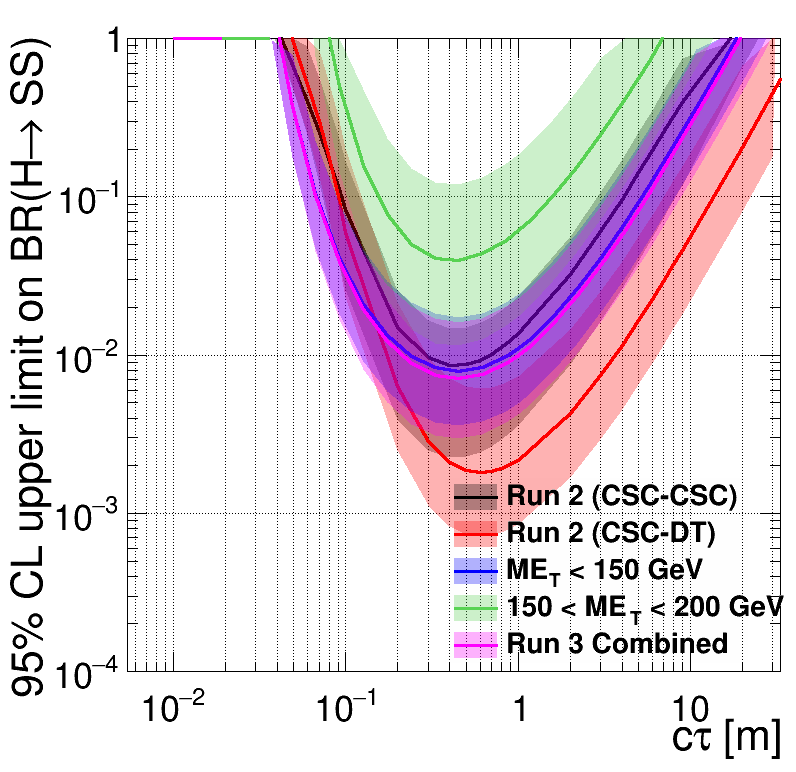

In [283]:
ctaus = np.array(limit_dict['comb']['ctau'])

canvas = TCanvas('','',800,800)
canvas.SetLogx()
canvas.SetLogy()
canvas.SetGrid()

legend = TLegend(0.56, 0.14, 0.94, 0.38)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kWhite, 0)
legend.SetTextSize(0.04)
legend.SetMargin(0.2)
ii = 0
names = {'run2_csccsc':'Run 2 (CSC-CSC)','run2_cscdt':'Run 2 (CSC-DT)','high' : '150 < ME_{T} < 200 GeV', 'low' : 'ME_{T} < 150 GeV', 'comb' : 'Run 3 Combined'}

# print(r'\begin{center}')
# print(r'\begin{tabular}{c|c|cc}')
# print(r'    & ct=1m ($\frac{limit}{run2}$) & best ct & best limit ($\frac{limit}{run2}$) \\')
# print(r'    \hline')

for il, name in enumerate([
        'run2_csccsc',
        'run2_cscdt',
        'low',
        'high',
        'comb'
    ]):
    if name in limit_dict:
        limits = np.array(limit_dict[name]['limit'])  #* 23/137#*23/(60*2) # # 
        limitELs = np.array(limit_dict[name]['2.5'])  #* 23/137#*23/(60*2) # # 
        limitEHs = np.array(limit_dict[name]['97.5']) # * 23/137#*23/(60*2) # # 

        _ctaus, _limits = ctaus/1000, limits
        _limitELs, _limitEHs = np.abs(_limits - limitELs), np.abs(limitEHs - _limits)
    elif name == 'run2_csccsc':
        _ctaus = r2_csccsc_limit_tree[:, 0]
        _limits = r2_csccsc_limit_tree[:, -1]
        _limitELs = np.abs(r2_csccsc_limit_tree[:, 1] - _limits)
        _limitEHs = np.abs(r2_csccsc_limit_tree[:, -2] - _limits)
    elif name == 'run2_cscdt':
        _ctaus = r2_cscdt_limit_tree[:, 0]
        _limits = r2_cscdt_limit_tree[:, -1]
        _limitELs = np.abs(r2_cscdt_limit_tree[:, 1] - _limits)
        _limitEHs = np.abs(r2_cscdt_limit_tree[:, -2] - _limits)
    
    gr = TGraphAsymmErrors(len(_ctaus), _ctaus*1., _limits*1., _ctaus*0., _ctaus*0., _limitELs*1., _limitEHs*1.)\
    
    lm1 = np.min(_limits[_ctaus==1])
    lmb = np.min(_limits)
    ctb = _ctaus[_limits == lmb][0]
    # r21 = np.min(r2_limit_tree[r2_limit_tree[:,0]==1,-1])
    # r2b = np.min(r2_limit_tree[:,-1])

    # print(f'    {name} & {lm1:.2e} ({lm1/r21:.1f}) & {ctb:.3f} & {lmb:.2e} ({lmb/r2b:.1f}) \\\\')
    gr.SetName(name)
    gr.SetName(names[name])
    gr.GetXaxis().SetTitle(r'c#tau [m]')
    gr.GetYaxis().SetTitle(r'95% CL upper limit on BR(H#rightarrow SS)')

    gr.SetMinimum(1e-4)
    gr.SetMaximum(1)

    gr.SetLineWidth(3)
    gr.SetLineColor(SCL[il])
    
    gr.SetMarkerSize(1)
    gr.SetMarkerColor(SCL[il])
    gr.SetMarkerStyle(rt.kFullCircle)

    gr.SetFillColorAlpha(SCL[il], 0.3)

    gr.Draw(('' if ii else 'A ') + 'L3')
    ii += 1
    legend.AddEntry(gr, gr.GetName(), 'LF')
    gc.append(gr)
# print(r'\end{tabular}')
# print(r'\end{center}')


legend.Draw()
canvas.Draw()


\begin{center}
\begin{tabular}{c|c|cc}
    & ct=1m (\frac{limit}{run2}) & best ct & best limit (\frac{limit}{run2}) \\
    \hline
    run2 & 1.36e-02 (1.0) & 0.400 & 8.63e-03 (1.0) \\
    comb & 1.79e-02 (0.8) & 0.621 & 1.64e-02 (0.5) \\
    comb_50 & 8.23e-03 (1.7) & 0.621 & 7.55e-03 (1.1) \\
    comb_137 & 3.00e-03 (4.5) & 0.621 & 2.75e-03 (3.1) \\
\end{tabular}
\end{center}


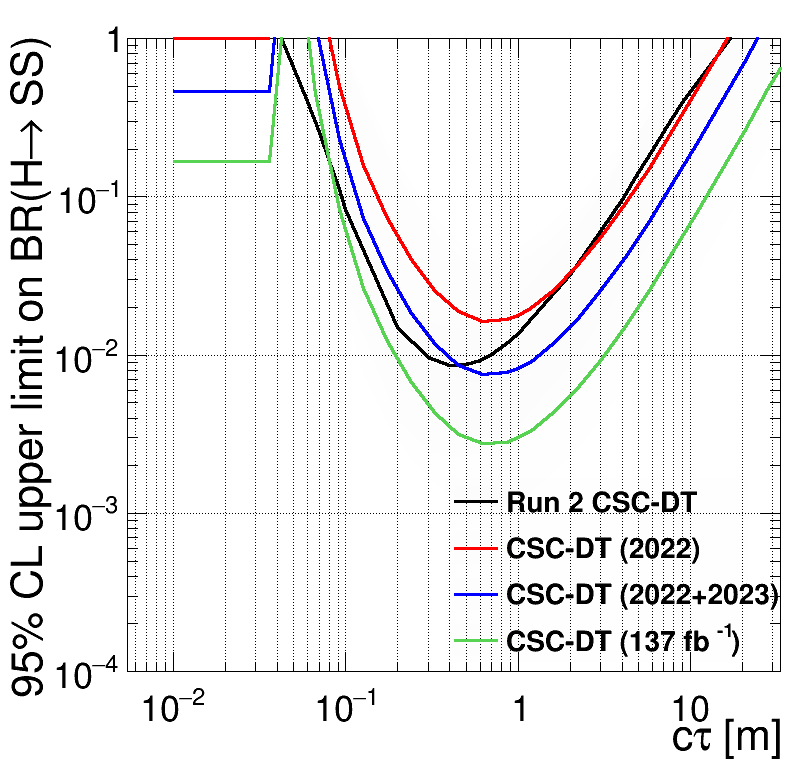

In [274]:
ctaus = np.array(limit_dict['comb']['ctau'])

canvas = TCanvas('','',800,800)
canvas.SetLogx()
canvas.SetLogy()
canvas.SetGrid()

legend = TLegend(0.56, 0.14, 0.94, 0.38)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kWhite, 0)
legend.SetTextSize(0.04)
legend.SetMargin(0.2)
ii = 0
names = {'run2':'Run 2 CSC-DT', 'comb' : 'CSC-DT (2022)', 'comb_50' : 'CSC-DT (2022+2023)', 'comb_137' : 'CSC-DT (137 fb^{-1})'}

print(r'\begin{center}')
print(r'\begin{tabular}{c|c|cc}')
print(r'    & ct=1m (\frac{limit}{run2}) & best ct & best limit (\frac{limit}{run2}) \\')
print(r'    \hline')

for il, name_ in enumerate(['run2', 'comb', 'comb_50', 'comb_137']):
    name = name_.split('_')[0]
    if name in limit_dict:
        limits = np.array(limit_dict[name]['limit'])
        limitELs = np.array(limit_dict[name]['2.5'])
        limitEHs = np.array(limit_dict[name]['97.5'])

        _ctaus, _limits = ctaus/1000, limits
        _limitELs, _limitEHs = np.abs(_limits - limitELs), np.abs(limitEHs - _limits)
        
    else:
        _ctaus = r2_limit_tree[:, 0]
        _limits = r2_limit_tree[:, -1]
        _limitELs = np.abs(r2_limit_tree[:, 1] - _limits)
        _limitEHs = np.abs(r2_limit_tree[:, -2] - _limits)

    if name_ == 'comb_50': # 2022 + 2023
        _limits =   _limits * 23/50
        _limitELs = _limitELs * 23/50
        limitEHs = limitEHs* 23/50
    if name_ == 'comb_137': # 2022 + 2023
        _limits =   _limits * 23/137
        _limitELs = _limitELs * 23/137
        _limitEHs = _limitEHs* 23/137

    gr = TGraphAsymmErrors(len(_ctaus), _ctaus*1., _limits*1., _ctaus*0., _ctaus*0., _limitELs*1., _limitEHs*1.)\
    
    lm1 = np.min(_limits[_ctaus==1])
    lmb = np.min(_limits)
    ctb = _ctaus[_limits == lmb][0]
    r21 = np.min(r2_limit_tree[r2_limit_tree[:,0]==1,-1])
    r2b = np.min(r2_limit_tree[:,-1])

    # print(f'    {name_} & {lm1:.2e} ({lm1/r21:.1f}) & {ctb:.3f} & {lmb:.2e} ({lmb/r2b:.1f}) \\\\')
    print(f'    {name_} & {lm1:.2e} ({r21/lm1:.1f}) & {ctb:.3f} & {lmb:.2e} ({r2b/lmb:.1f}) \\\\')
    gr.SetName(name_)
    gr.SetName(names[name_])
    gr.GetXaxis().SetTitle(r'c#tau [m]')
    gr.GetYaxis().SetTitle(r'95% CL upper limit on BR(H#rightarrow SS)')

    gr.SetMinimum(1e-4)
    gr.SetMaximum(1)

    gr.SetLineWidth(3)
    gr.SetLineColor(SCL[il])

    gr.SetMarkerSize(1)
    gr.SetMarkerColor(SCL[il])
    gr.SetMarkerStyle(rt.kFullCircle)

    gr.SetFillColorAlpha(SCL[il], 0.3)


    # if il > 1:
        # gr.SetLineStyle(rt.kDashed)
    gr.SetFillColorAlpha(SCL[il], 0)


    gr.Draw(('' if ii else 'A ') + 'L3')
    ii += 1
    legend.AddEntry(gr, gr.GetName(), 'LF')
    gc.append(gr)
print(r'\end{tabular}')
print(r'\end{center}')


legend.Draw()
canvas.Draw()
